# Stan analysis of an LMM with two vector-valued random effects terms

Consider the example

In [1]:
Pkg.update();
Pkg.add("MixedModels");
using DataFrames,MixedModels,Mamba,Stan

INFO: Updating METADATA...
INFO: Updating JuliaBox...
INFO: Updating Interact...
INFO: Updating Homework...
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Nothing to be done


Environment variable JULIA_SVG_BROWSER not found.


In [2]:
bs10 = MixedModels.rdata("bs10");
names(bs10)

12-element Array{Symbol,1}:
 :SubjID
 :ItemID
 :Spkr  
 :Filler
 :ms    
 :d     
 :d2    
 :Spkr2 
 :dif   
 :SF    
 :F     
 :S     

The _maximal model_, according to Barr et al. (2012), is 

In [3]:
m0 = fit(lmm(dif ~ 1+S+F+SF + (1+S+F+SF|SubjID) + (1+S+F+SF|ItemID), bs10))

Linear mixed model fit by maximum likelihood
Formula: dif ~ 1 + S + F + SF + ((1 + S + F + SF) | SubjID) + ((1 + S + F + SF) | ItemID)

 logLik: -515.477648, deviance: 1030.955295

 Variance components:
                Variance    Std.Dev.  Corr.
 SubjID         0.013393    0.115730
                0.011216    0.105907  -0.56
                0.003373    0.058075   0.99  0.99
                0.005192    0.072053  -0.13 -0.13 -0.13
 ItemID         0.000305    0.017459
                0.000079    0.008904  -1.00
                0.000136    0.011647   1.00  1.00
                0.000083    0.009125  -1.00 -1.00 -1.00
 Residual       0.127779    0.357462
 Number of obs: 1104; levels of grouping factors: 92, 12

  Fixed-effects parameters:
               Estimate Std.Error  z value
(Intercept)    0.039221 0.0169329  2.31626
S            -0.0174094 0.0156289 -1.11392
F             0.0174819 0.0127947  1.36633
SF           -0.0322645 0.0133832 -2.41082


In [4]:
gc();@time fit(lmm(dif ~ 1+S+F+SF + (1+S+F+SF|SubjID) + (1+S+F+SF|ItemID), bs10));

elapsed time: 0.87789873 seconds (243276856 bytes allocated, 25.79% gc time)


The correlations of the `ItemID` random effects indicate singularity.  (Note that there are only 12 distinct items.)  A check of the λ matrices 

In [5]:
m0.λ

2-element Array{Any,1}:
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.323755    0.0         0.0         0.0
 -0.166342    0.24517     0.0         0.0
  0.161121   -0.0208524   1.28294e-6  0.0
 -0.0265681   0.199809   -1.86675e-6  0.0)    
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.048841    0.0         0.0          0.0
 -0.0249089   9.798e-7    0.0          0.0
  0.0325814  -7.88577e-8  0.0          0.0
 -0.0255267  -3.63929e-8  5.09367e-10  0.0)

indicates that both are singular.  In a case like this we can zero out the very small values in the parameter vector (these are the elements on and below the diagonal of the λ matrices) without increasing the deviance.

In [6]:
deviance(m0)

1030.9552950545328

In [7]:
MixedModels.objective!(m0,
   Float64[abs(x) < 5e-6 ? 0. : x for x in MixedModels.θ(m0)])

1030.9552950535974

In [8]:
m0.λ

2-element Array{Any,1}:
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.323755    0.0        0.0  0.0
 -0.166342    0.24517    0.0  0.0
  0.161121   -0.0208524  0.0  0.0
 -0.0265681   0.199809   0.0  0.0)
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.048841   0.0  0.0  0.0
 -0.0249089  0.0  0.0  0.0
  0.0325814  0.0  0.0  0.0
 -0.0255267  0.0  0.0  0.0)                            

## MCMC for the maximal model using Stan

We define a [Stan](http://mc-stan.org) model similar to that used for `VectorOne`

In [9]:
VectorTwo = """
data {
  int<lower=0>  N; // num observations
  int<lower=1>  K; // length of fixed-effects vector
  int<lower=0>  M; // num subjects
  int<lower=1>  J; // length of subj vector-valued random effects
  int<lower=0>  L; // num items
  int<lower=1>  I; // length of item vector-values random effects
  int<lower=1,upper=M> subj[N]; // subject indicator
  int<lower=1,upper=L> item[N]; // item indicator
  row_vector[K] X[N]; // model matrix for fixed-effects parameters
  row_vector[J] Zs[N]; // generator model matrix for subj random effects
  row_vector[I] Zi[N]; // generator model matrix for item random effects 
  vector[N]     y; // response vector (reaction time)
}

parameters {
  cholesky_factor_corr[J] Ls; // Cholesky factor of subj r.e. correlations
  cholesky_factor_corr[I] Li; // Cholesky factor of item r.e. correlations
  vector<lower=0>[J] taus; // standard deviations of unconditional subj r.e. dist
  vector<lower=0>[I] taui; // standard deviations of unconditional item r.e. dist
  vector[J] us[M];     // spherical subj random effects
  vector[I] ui[L];     // spherical item random effects
  vector[K] beta;      // fixed-effects
  real<lower=0> sigma; // standard deviation of response given random effects
}

transformed parameters {
  matrix[J,J] corrs;
  matrix[I,I] corri;
  corrs <- tcrossprod(Ls);  // for monitoring subj correlations
  corri <- tcrossprod(Li);  // for monitoring item correlations
}

model {
  matrix[J,J] Lambdas; 
  vector[J] bs[M];
  matrix[I,I] Lambdai; 
  vector[I] bi[L];
  taus ~ cauchy(0,2.5);
  taui ~ cauchy(0,2.5);
  Ls ~ lkj_corr_cholesky(2);
  Li ~ lkj_corr_cholesky(2);
  Lambdas <- diag_pre_multiply(taus,Ls);
  Lambdai <- diag_pre_multiply(taui,Li);
  for (m in 1:M) {
    us[m] ~ normal(0,1);
    bs[m] <- Lambdas * us[m];
  }
  for (l in 1:L) {
    ui[l] ~ normal(0,1);
    bi[l] <- Lambdai * ui[l];
  }
  for (n in 1:N)
    y[n] ~ normal(X[n] * beta + Zs[n] * bs[subj[n]] + Zi[n] * bi[item[n]], sigma);
}
""";

In [10]:
X = m0.X.m;
const bs10data = [
    @Compat.Dict("N" => size(X,1),
    "K" => size(X,2),
    "M" => length(bs10[:SubjID].pool),
    "J" => size(X,2),
    "L" => length(bs10[:ItemID].pool),
    "I" => size(X,2),
    "subj" => bs10[:SubjID].refs,
    "item" => bs10[:ItemID].refs,
    "y" => m0.y,
    "X" => X,
    "Zs" => X,
    "Zi" => X)
];

In [11]:
monitor = ["lp__", "accept_stat__","sigma",
    "beta.1","beta.2","beta.3","beta.4",
    "corrs.2.1","corrs.3.1","corrs4.1","corrs.3.2","corrs.4.2","corrs.4.3",
    "taus.1","taus.2","taus.3","taus.4",
    "corri.2.1","corri.3.1","corri4.1","corri.3.2","corri.4.2","corri.4.3",
    "taui.1","taui.2","taui.3","taui.4"];
bs10model = Stanmodel(name="bs10",model=VectorTwo,monitors=monitor,nchains=10);


File /home/juser/notebooks/tmp/bs10.stan will be updated.



In [13]:
sim1 = stan(bs10model, bs10data);



--- Translating Stan model to C++ code ---
bin/stanc /home/juser/notebooks/tmp/bs10.stan --o=/home/juser/notebooks/tmp/bs10.cpp --no_main
Model name=bs10_model
Input file=/home/juser/notebooks/tmp/bs10.stan
Output file=/home/juser/notebooks/tmp/bs10.cpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan/src -isystem stan/lib/eigen_3.2.0 -isystem stan/lib/boost_1.54.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-local-typedefs  -lpthread  -O3 -o /home/juser/notebooks/tmp/bs10 src/cmdstan/main.cpp -include /home/juser/notebooks/tmp/bs10.cpp -Lbin -lstan

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Inference for Stan model: bs10_model
10 chains: each with iter=(1000,1000,1000,1000,1000,1000,1000,1000,1000,1000); warmup=(0,0,0,0,0,0,0,0,0,0); thin=(1,1,1,1,1,1,1,1,1,1); 10000 iterations saved.

Warmup took (43, 48, 39, 48, 38, 43, 51, 42, 43, 45) seconds, 7.3 minutes total
Sampl

In [14]:
describe(sim1)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4,5,6,7,8,9,10
Samples per chain = 1000

Empirical Posterior Estimates:
26x6 Array{Any,2}:
 ""                  "Mean"      "SD"       …   "MCSE"           "ESS"
 "lp__"           333.277      19.7768         0.333394      5931.97  
 "accept_stat__"    0.893092    0.11797        0.00113733   10000.0   
 "taus.1"           0.115234    0.0154843      0.000229272   6753.7   
 "taus.2"           0.106583    0.0152033      0.000191926   7921.44  
 "taus.3"           0.0562767   0.0147539   …  0.000185442   7956.07  
 "taus.4"           0.0719902   0.0164709      0.000197655   8333.16  
 "taui.1"           0.0209939   0.0155054      0.00020159    7691.56  
 "taui.2"           0.0148742   0.0120587      0.000146556   8228.03  
 "taui.3"           0.0158641   0.0126816      0.00018409    6888.77  
 "taui.4"           0.0165452   0.0129576   …  0.00016709    7754.88  
 "beta.1"           0.0389865   0.017738       0.000247488   7167.23  


In [15]:
p = plot(sim1,[:trace,:density]);

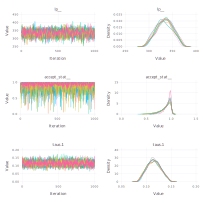

Press ENTER to draw next plot
STDIN> 


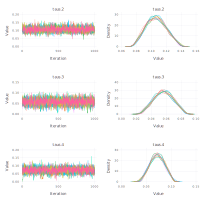

Press ENTER to draw next plot
STDIN> 


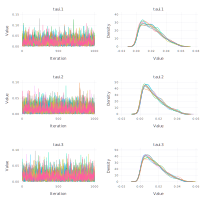

Press ENTER to draw next plot
STDIN> 


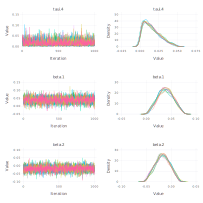

Press ENTER to draw next plot
STDIN> 


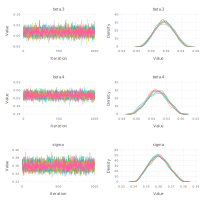

Press ENTER to draw next plot
STDIN> 


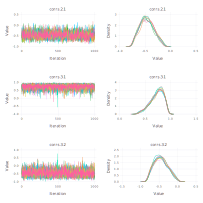

Press ENTER to draw next plot
STDIN> 


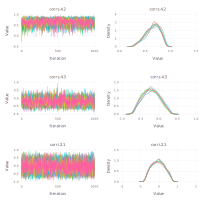

Press ENTER to draw next plot
STDIN> 


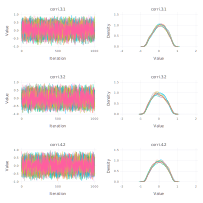

Press ENTER to draw next plot
STDIN> 


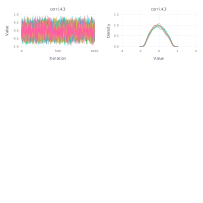

In [16]:
draw(p)